In [2]:
%pylab inline
import scanpy as sc
import pandas as pd
import seaborn as sns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### cd8t_b_mono_cell_embedding

In [3]:
hvgdf = pd.read_csv('./data/zheng68k_train_var.csv',index_col=0)
selected_gene = hvgdf.highly_variable.values

cell_geneemb = np.load('./data/cd8t_b_mono_geneemb_01B-resolution_singlecell_gene_embedding_f1_resolution.npy')

geneemb_merge = cell_geneemb[:,selected_gene,:].mean(0)
geneemb_merge.shape

(495, 512)

In [5]:
gene_list_df = pd.read_csv('../OS_scRNA_gene_index.19264.tsv', header=0, delimiter='\t')
gene_list = list(gene_list_df['gene_name'])

In [6]:
gene_adata=sc.AnnData(pd.DataFrame(geneemb_merge,index=np.array(gene_list)[selected_gene]))
sc.pp.neighbors(gene_adata,use_rep='X')
sc.tl.umap(gene_adata)

/opt/conda/envs/scvi/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
sc.tl.leiden(gene_adata,resolution=5)

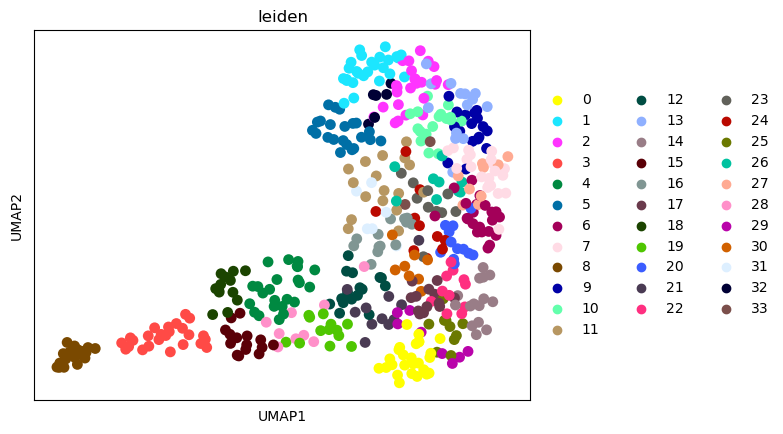

In [8]:
sc.pl.umap(gene_adata,color='leiden')

In [9]:
# The function is modified from https://github.com/bowang-lab/scGPT
import collections
def get_metagenes(gdata):
    metagenes = collections.defaultdict(list)
    for x, y in zip(gdata.obs["leiden"], gdata.obs.index):
        metagenes[x].append(y)
    return metagenes

metagenes = get_metagenes(gene_adata)

# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [102]:
import pickle
with open ('mgs.pkl','wb') as f:
    pickle.dump(mgs,f)

In [10]:
len(mgs)

33

In [11]:
# The function is modified from https://github.com/bowang-lab/scGPT

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
def score_metagenes(adata, metagenes):
    for p, genes in tqdm(metagenes.items()):
        try:
            sc.tl.score_genes(adata, score_name=str(p) + "_SCORE", gene_list=genes)
            scores = np.array(adata.obs[str(p) + "_SCORE"].tolist()).reshape(-1, 1)
            scaler = MinMaxScaler()
            scores = scaler.fit_transform(scores)
            scores = list(scores.reshape(1, -1))[0]
            adata.obs[str(p) + "_SCORE"] = scores
        except Exception as e:
            adata.obs[str(p) + "_SCORE"] = 0.0

In [12]:
adata = sc.read_h5ad('./data/zheng_downsampled_cd8t_b_mono.h5ad')

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

score_metagenes(adata,mgs)

  0%|          | 0/33 [00:00<?, ?it/s]/opt/conda/envs/scvi/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/conda/envs/scvi/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/conda/envs/scvi/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/opt/conda/envs/scvi/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut

In [13]:
scorelist = [x for x in adata.obs.columns if x.__contains__('SCORE')]
genescoreadata = sc.AnnData(adata.obs[scorelist])
genescoreadata.obs = adata.obs.iloc[:,:3].copy()
sc.tl.rank_genes_groups(genescoreadata,groupby='label')

/tmp/ipykernel_67750/751428128.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  genescoreadata = sc.AnnData(adata.obs[scorelist])


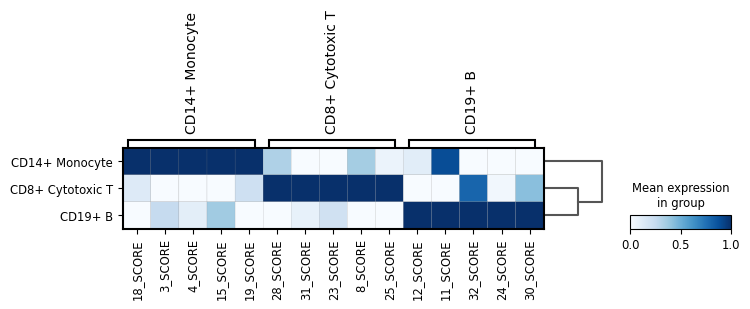

In [14]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.rank_genes_groups_matrixplot(genescoreadata, n_genes=5, standard_scale='var', cmap='Blues',save='celltype_module')

In [15]:
print(mgs['18'],'\n',mgs['28'],'\n',mgs['12'])

['ANXA2', 'CTSS', 'GPX1', 'IL32', 'KLF6', 'NFKBIA', 'NPC2', 'PSAP', 'PYCARD', 'S100A11', 'S100A9', 'SRGN', 'TYMP'] 
 ['CD8A', 'CD8B', 'CST7', 'CTSW', 'GNLY', 'GZMA', 'NKG7', 'S100A8', 'TCL1A'] 
 ['AQP3', 'CD14', 'EAF2', 'FCER2', 'FCGR2B', 'FCRLA', 'HLA-DOB', 'HMOX1', 'IGLL5', 'LRRC25', 'MS4A1', 'P2RX5', 'PLD4', 'PMAIP1', 'SPIB', 'VPREB3']


In [16]:
geneemb_mergedf = pd.DataFrame(geneemb_merge,index=np.array(gene_list)[selected_gene])
genesub = mgs['28']
cd8tembdf = geneemb_mergedf.loc[genesub].copy()

In [17]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
# The function is modified from https://github.com/bowang-lab/scGPT
G = nx.Graph()
similarities = cosine_similarity(cd8tembdf)
genes = list(cd8tembdf.index.values)
similarities[similarities>0.9999]=0
edges = []
nz = list(zip(*similarities.nonzero()))
for n in tqdm(nz):
    edges.append((genes[n[0]], genes[n[1]],{'weight':similarities[n[0],n[1]]}))
G.add_nodes_from(genes)
G.add_edges_from(edges)

100%|██████████| 72/72 [00:00<00:00, 627837.60it/s]


In [19]:
widths = nx.get_edge_attributes(G, 'weight')
weightvalue = np.array(list(widths.values()))
scaled_weightvalue = (weightvalue-weightvalue.min())/(weightvalue.max()-weightvalue.min())*3

In [20]:
widsorted = sorted(widths.items(), key=lambda x: x[1], reverse=True)

In [21]:
toppair = np.array(list(widths))[weightvalue.argsort()<3]

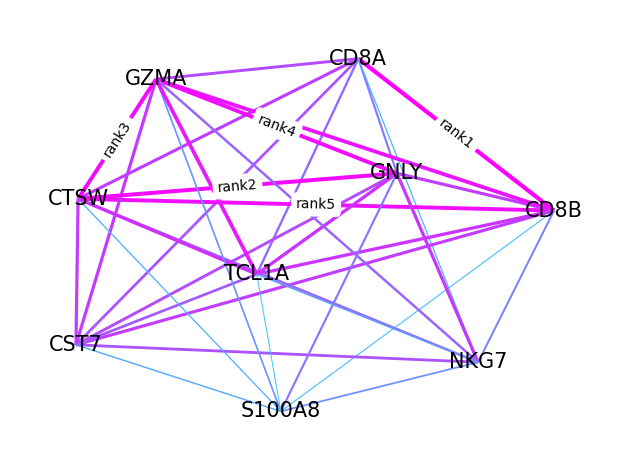

In [22]:
pos = nx.spring_layout(G, k=0.4, iterations=15, seed=42)

nx.draw_networkx_edges(G, pos,
                       edgelist = widths.keys(),
                       edge_color=list(widths.values()),
                       width=scaled_weightvalue,
                       edge_cmap=mpl.colormaps['cool'],
                       alpha=1)

nx.draw_networkx_labels(G, pos, font_size=15, font_family="sans-serif")

# edge weight labels
edge_labels = {widsorted[i][0]: f'rank{i+1}' for i in range(5)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
plt.savefig('figures/T_genemodule.pdf',bbox_inches='tight')

## Use emb for pySCENIC

In [23]:
cell_geneemb = np.load('./data/cd8t_b_mono_geneemb_01B-resolution_singlecell_gene_embedding_f1_resolution.npy')

In [25]:
selected_gene = adata.X.sum(0)>0
geneemb_merge = cell_geneemb[:,selected_gene,:].mean(0)
geneemb_merge.shape

(9160, 512)

In [26]:
TF = pd.read_csv('./data/allTFs_hg38.txt',header=None).values.T[0]
sgene = np.array(gene_list)[selected_gene]
fltTF = [x for x in TF if x in sgene]
len(fltTF)

993

In [27]:
fltgeneembdf = pd.DataFrame(geneemb_merge,index=sgene)

In [28]:
coexplist=[]
for tf in tqdm(fltTF):
    tmpsim = cosine_similarity(fltgeneembdf.loc[fltTF[0],:].values.reshape(1,-1),fltgeneembdf)
    tmpsim[tmpsim>0.9999]=0
    tmpsimdf = pd.DataFrame(tmpsim,columns=sgene,index=['simi']).T
    tmpsimdf = tmpsimdf.sort_values('simi',ascending=False)
    for idx in range(1000):
        coexplist.append([tf,tmpsimdf.index[idx],tmpsimdf.iloc[idx,0]*100])

100%|██████████| 993/993 [01:55<00:00,  8.63it/s]


In [29]:
grndf = pd.DataFrame(coexplist,columns=['TF','target','importance'])

In [30]:
grndf.to_csv('scf_grn_1000.tsv',index=False,sep='\t')

In [31]:
grndf.head()

,TF,target,importance
0,KLF12,MCTP2,99.810070
1,KLF12,PRKCQ,99.802303
2,KLF12,MAPK8,99.799156
3,KLF12,ATP8A1,99.798155
4,KLF12,ADARB1,99.797648


feed into pyscenic

#bin/bash

docker run -it --rm \
    -v /nfs_beijing/:/nfs_beijing/ \
    aertslab/pyscenic:0.12.1 pyscenic ctx \
        ./geneemb/scf_grn_1000.tsv \
        ./geneemb/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
        --annotations_fname ./geneemb/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
        --expression_mtx_fname ./geneemb/data/zheng_subset_cd8t_b_mono.tsv \
        --mode "custom_multiprocessing" \
        --output ./geneemb/regulons_1000.csv \
        --num_workers 40
        
docker run -it --rm \
    -v /nfs_beijing/:/nfs_beijing/ \
    aertslab/pyscenic:0.12.1 pyscenic aucell \
        ./geneemb/data/zheng_subset_cd8t_b_mono.tsv \
        ./geneemb/regulons_1000.csv \
        -o ./geneemb/auc_mtx_1000.csv \
        --num_workers 6

In [ ]:
# from another notebook for post-analysis
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
from pyscenic.binarization import binarize

In [3]:
auc_mtx = pd.read_csv('./auc_mtx_1000.csv',index_col=0)

In [4]:
cellanno = pd.DataFrame(['CD8+ Cytotoxic T']*100+['CD19+ B']*100+['CD14+ Monocyte']*100,columns=['anno'])

In [6]:
rss_cellType = regulon_specificity_scores( auc_mtx, cellanno['anno'] )
rss_cellType.to_csv('RSS.csv')
rss_cellType

,ATF2(+),ATF4(+),BCL11A(+),BCLAF1(+),BPTF(+),CHURC1(+),CREB3L2(+),CUX1(+),DBP(+),DNMT1(+),...,YY1(+),ZBTB7A(+),ZBTB7B(+),ZNF18(+),ZNF576(+),ZNF580(+),ZNF740(+),ZNF846(+),ZNF880(+),ZNF90(+)
CD8+ Cytotoxic T,0.196936,0.338330,0.242308,0.376031,0.404179,0.329306,0.250411,0.208702,0.405880,0.291323,...,0.422363,0.294756,0.420049,0.423310,0.414587,0.267448,0.336347,0.220191,0.244541,0.402532
CD19+ B,0.219968,0.397652,0.282933,0.347184,0.436023,0.352227,0.310705,0.197598,0.420401,0.270033,...,0.422225,0.267871,0.429363,0.437026,0.427848,0.239278,0.399233,0.230495,0.204455,0.449048
CD14+ Monocyte,0.184010,0.352036,0.236480,0.350613,0.347149,0.347885,0.204871,0.318069,0.337365,0.268749,...,0.379621,0.229403,0.394179,0.385300,0.384754,0.247373,0.338687,0.199447,0.202466,0.362034


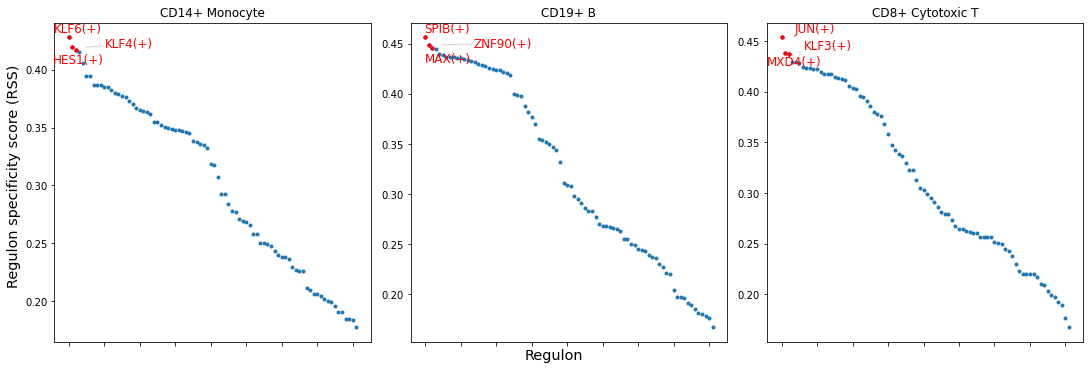

In [8]:
from adjustText import adjust_text
cats = sorted(list(set(cellanno['anno'])))

fig = plt.figure(figsize=(15, 5))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,3,num)
    plot_rss(rss_cellType, c, top_n=3, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.savefig('RSS.pdf',bbox_inches='tight')